In [20]:
# Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import re

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Load the full KJB and split those lines.

with open('drive/MyDrive/Colab_Notebooks/Byble/Bible_King_James.txt', 'r') as kjb:
  kbj_txt = kjb.read()

kjb_list = kbj_txt.splitlines()

In [30]:
# Find Psalms and extract it separately.

psalm_minindex = kjb_list.index('The Book of Psalms')
psalm_maxindex = kjb_list.index('The Proverbs')

psalm_list = kjb_list[psalm_minindex:psalm_maxindex]

In [31]:
psalm_list[:23]

['The Book of Psalms',
 '',
 '',
 '1:1 Blessed is the man that walketh not in the counsel of the ungodly,',
 'nor standeth in the way of sinners, nor sitteth in the seat of the',
 'scornful.',
 '',
 '1:2 But his delight is in the law of the LORD; and in his law doth he',
 'meditate day and night.',
 '',
 '1:3 And he shall be like a tree planted by the rivers of water, that',
 'bringeth forth his fruit in his season; his leaf also shall not',
 'wither; and whatsoever he doeth shall prosper.',
 '',
 '1:4 The ungodly are not so: but are like the chaff which the wind',
 'driveth away.',
 '',
 '1:5 Therefore the ungodly shall not stand in the judgment, nor sinners',
 'in the congregation of the righteous.',
 '',
 '1:6 For the LORD knoweth the way of the righteous: but the way of the',
 'ungodly shall perish.',
 '']

In [35]:
# Parse the Psalms by eliminating the verses and the title, while lowering their case.

psalm_txt = '\n'.join(psalm_list)

psalm_txt_novers = re.sub("\d+\:\d+",'',psalm_txt)
psalm_txt_novers = re.sub("The Book of Psalms ",'',psalm_txt_novers)
corpus = psalm_txt_novers.lower()
corpus = corpus.lower().split("\n")  # the corpus should be a list of the rows of text.


In [39]:
# Tokenization. 

tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)                    # Fit the Tokenizer to the whole corpus
total_words = len(tokenizer.word_index) + 1

input_sequences = []

for line in corpus:
  if len(line)!=0:                                # Since there are blank rows, I wanted to tokenize rows that weren't blank.
    token_list = tokenizer.texts_to_sequences([line])[0]   # Since 'line' has the text row, it has to be entered into brackets, otherwise, the texts_to_sequences will fit the token indexes into each character.
    for i in range(1, len(token_list)):
      n_gram_sequence = token_list[:i+1]                   # create an n_gram list with group of consecutive words. This way, the model will learn which words should go after which other words, depending on the sentence context. Starting with the first word onward.
      input_sequences.append(n_gram_sequence)

print(len(tokenizer.word_index))

2905


In [40]:
# Find out what is the maximum length of rows according to their word count, which will subsequently be used to pad all smaller sequence rows.

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

print(max_sequence_len)
print(np.shape(input_sequences))

17
(37865, 17)


In [41]:
# Create the training data (xs), training labels (labels) and transforming the latter into a One-Hot encoded matrix (ys)
xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]
ys = to_categorical(labels, num_classes=total_words)

print(np.shape(xs))
print(np.shape(labels))
print(np.shape(ys))

(37865, 16)
(37865,)
(37865, 2906)


In [46]:
# RNN model creation, with early-stopping included.

model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len - 1))
model.add(Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)))
model.add(Bidirectional(tf.keras.layers.LSTM(250)))
model.add(Dense(200, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=500, verbose=1, callbacks=EarlyStopping(patience=10, monitor='accuracy'))

Epoch 1/500
1184/1184 [==============================] - 20s 12ms/step - loss: 5.6357 - accuracy: 0.0975
Epoch 2/500
1184/1184 [==============================] - 15s 12ms/step - loss: 5.0449 - accuracy: 0.1384
Epoch 3/500
1184/1184 [==============================] - 15s 12ms/step - loss: 4.7778 - accuracy: 0.1611
Epoch 4/500
1184/1184 [==============================] - 15s 12ms/step - loss: 4.5874 - accuracy: 0.1754
Epoch 5/500
1184/1184 [==============================] - 15s 12ms/step - loss: 4.4344 - accuracy: 0.1899
Epoch 6/500
1184/1184 [==============================] - 15s 12ms/step - loss: 4.2935 - accuracy: 0.1990
Epoch 7/500
1184/1184 [==============================] - 15s 13ms/step - loss: 4.1640 - accuracy: 0.2120
Epoch 8/500
1184/1184 [==============================] - 15s 13ms/step - loss: 4.0443 - accuracy: 0.2189
Epoch 9/500
1184/1184 [==============================] - 15s 13ms/step - loss: 3.9372 - accuracy: 0.2273
Epoch 10/500
1184/1184 [==============================]

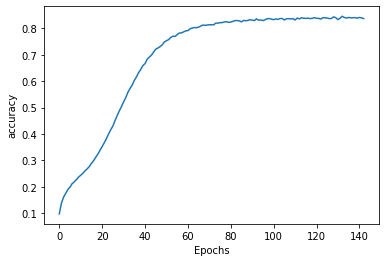

In [47]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

In [54]:
# Test the Psalm Generator out!!

seed_text = "I love the"
next_words = 20                             # I want the model to tell me the next 20 words that should go after the seed_text.
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]                             # Creating a texts_to_sequences on the seed_text.
  token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')  # Pad them sequences.
  probabilities = model.predict(token_list, verbose=0)                                  # Predict the output, and since it is associated to probabilities...
  predicted = np.argmax(probabilities, axis= - 1)[0]                                    # ... extract the word with the highest probability.
  output_word = tokenizer.index_word[predicted]                                         # the latter output is an index of the word, which means, I will use it to find the actual word string.
  seed_text += " " + output_word                                                        # Construct the Paslm verse.
print(seed_text)

I love the  lord because he hath heard my voice and my salvation and let me not not be remembered for ever in
